In [4]:
# iPython extension to autoreload modules when changes are made without restarting kernel
%load_ext autoreload
%autoreload 2

## Create Environment and Set up Simulation 

In [5]:
from functions.simulation_setup import set_schema_buildings, set_active_observations, set_schema_simulation_period
from citylearn.data import DataSet


print('All CityLearn datasets:', sorted(DataSet().get_dataset_names()))
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet().get_schema(DATASET_NAME)

RANDOM_SEED = 0
BUILDING_COUNT = 2
DAY_COUNT = 7
ACTIVE_OBSERVATIONS = ['hour', 'month']

schema, buildings = set_schema_buildings(schema, BUILDING_COUNT, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, DAY_COUNT, RANDOM_SEED)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)
schema['central_agent'] = True


print('Selected buildings:', buildings)
print(
    f'Selected {DAY_COUNT}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', ACTIVE_OBSERVATIONS)


All CityLearn datasets: ['baeda_3dem', 'ca_alameda_county_neighborhood', 'citylearn_challenge_2020_climate_zone_1', 'citylearn_challenge_2020_climate_zone_2', 'citylearn_challenge_2020_climate_zone_3', 'citylearn_challenge_2020_climate_zone_4', 'citylearn_challenge_2021', 'citylearn_challenge_2022_phase_1', 'citylearn_challenge_2022_phase_2', 'citylearn_challenge_2022_phase_3', 'citylearn_challenge_2022_phase_all', 'citylearn_challenge_2022_phase_all_plus_evs', 'citylearn_challenge_2023_phase_1', 'citylearn_challenge_2023_phase_2_local_evaluation', 'citylearn_challenge_2023_phase_2_online_evaluation_1', 'citylearn_challenge_2023_phase_2_online_evaluation_2', 'citylearn_challenge_2023_phase_2_online_evaluation_3', 'citylearn_challenge_2023_phase_3_1', 'citylearn_challenge_2023_phase_3_2', 'citylearn_challenge_2023_phase_3_3', 'quebec_neighborhood_with_demand_response_set_points', 'quebec_neighborhood_without_demand_response_set_points', 'tx_travis_county_neighborhood', 'vt_chittenden_co

## Base Agent

In [24]:
from agents.baseagent import Agent, BaselineAgent
from citylearn.citylearn import CityLearnEnv

base_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
base_agent = BaselineAgent(base_env, random_seed=RANDOM_SEED)

# Initialize Environment
observations, _ = base_env.reset()

while not base_env.terminated:
    actions = base_agent.predict(observations)
    observations, reward, info, terminated, truncated = base_env.step(actions)

# test
kpis = base_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')


In [ ]:
# A general environment with discrete observations and actions that can be re-used for multiple agent types
from functions.wrappers import DiscreteAlgorithmWrapper

discrete_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
# Very Large bins and low multiplier for testing purposes

# define active observations and actions and their bin sizes
observation_bins = {'hour': 24, 'month':12}
action_bins = {'electrical_storage': 2, 'heating_storage': 2}

# Timesteps of simulation per possible state-action pair when simulating
# Higher for more computationally intensive, more thorough simulations
execution_multiplier = 3

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in discrete_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

unwrapped_env = DiscreteAlgorithmWrapper(
    discrete_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)
m = unwrapped_env.observation_space[0].n
n = unwrapped_env.action_space[0].n
t = unwrapped_env.time_steps - 1
num_episodes = int(m*n*execution_multiplier/t)
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', num_episodes)


Q-Table dimension: (324, 4)
Number of episodes to train: 23


c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.time_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.time_steps` for environment variables or `env.get_wrapper_attr('time_steps')` that will search the reminding wrappers.
  logger.warn(


# Train Tabular Models
## Q-Learning
Sampling based on CityLearn Implementation to create framework for how we will test and implement our new algorithms

In [45]:
from agents.q_learning import QLearning
from IPython.display import display

# This made for Tabular Q learning, but I think it applies to any discrete algorithm
q_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
q_env = DiscreteAlgorithmWrapper(
    q_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

q_kwargs = {
    'epsilon': 1.0,
    'epsilon_decay': True,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

q_agent = QLearning(
    env=q_env,
    random_seed=RANDOM_SEED,
    **q_kwargs
)

# ----------------- Train -----------------
_ = q_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = q_env.reset()

while not q_env.terminated:
    actions = q_agent.predict(observations, True)
    observations, reward, info, terminated, truncated = q_env.step(actions)

kpis = q_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 23/23 [00:21<00:00,  1.08it/s]
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be 

name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,1.530
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,1.414,1.219,1.317
cost_total,1.262,1.137,1.199
daily_one_minus_load_factor_average,NaN,NaN,0.971
daily_peak_average,NaN,NaN,1.373
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


## SARSA Model

In [51]:
from agents.sarsa import Sarsa

sarsa_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
sarsa_env = DiscreteAlgorithmWrapper(
    sarsa_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

sarsa_kwargs = {
    'epsilon': 0.1,
    'alpha': 0.005,
    'gamma': 0.99,
}


sarsa_agent = Sarsa(
    env=sarsa_env,
    random_seed=RANDOM_SEED,
    **sarsa_kwargs
)
# ----------------- Train -----------------
_ = sarsa_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sarsa_env.reset()

while not sarsa_env.terminated:
    actions = sarsa_agent.predict(observations, True)
    observations, reward, info, terminated, truncated = sarsa_env.step(actions)

kpis = sarsa_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do

name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,2.439
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,1.788,2.061,1.924
cost_total,1.555,1.805,1.680
daily_one_minus_load_factor_average,NaN,NaN,0.952
daily_peak_average,NaN,NaN,2.894
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


# Train Function Approximation Models
## Soft-Actor Critic

In [11]:
from agents.sac import SAC

sac_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)

sac_kwargs = {
    'mini_batch_size':5,
    'tau': 0.005,
    'entropy_coeff': 0.2,
    'gamma': 0.99,
}


sac_agent = SAC(
    env=sac_env,
    random_seed=RANDOM_SEED,
    **sac_kwargs
)
# ----------------- Train -----------------
_ = sac_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sac_env.reset()

while not sac_env.terminated:
    actions = sac_agent.predict(observations)
    observations, reward, info, terminated, truncated = sac_env.step(actions)

kpis = sac_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

  0%|          | 0/23 [00:00<?, ?it/s]c:\Users\raffy\Documents\GitHub\Fa24-CS-138-FinalProject\agents\sac.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  actions = torch.FloatTensor(actions, device=self.device)
100%|██████████| 23/23 [00:38<00:00,  1.67s/it]


name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,1.0
annual_normalized_unserved_energy_total,0.0,0.0,0.0
carbon_emissions_total,1.0,1.0,1.0
cost_total,1.0,1.0,1.0
daily_one_minus_load_factor_average,NaN,NaN,1.0
daily_peak_average,NaN,NaN,1.0
discomfort_cold_delta_average,0.0,0.0,0.0
discomfort_cold_delta_maximum,0.0,0.0,0.0
discomfort_cold_delta_minimum,0.0,0.0,0.0


## MADDPG

In [80]:
from agents.maddpg import MADDPGAgent, ReplayBuffer
import numpy as np

MADDPG_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
steps_per_episode = MADDPG_env.episode_time_steps
obs = MADDPG_env.reset()

num_agents = len(MADDPG_env.buildings)
obs_dim = len(obs[0])
act_dim = MADDPG_env.action_space[0].shape[0]
device = 'cpu'

print("Active Observations: ", MADDPG_env.observation_names)
print("Active Actions: ", MADDPG_env.action_names)

MADDPG_agent = MADDPGAgent(num_agents=num_agents, 
                           obs_dim=obs_dim, 
                           act_dim=act_dim,
                           device='cpu')

replay_buffer = ReplayBuffer(obs_dim=obs_dim, 
                             act_dim=act_dim,
                             num_agents=num_agents, 
                             device='cpu')

# ----------------- Train -----------------
for ep in range(num_episodes):
    obs, _ = MADDPG_env.reset()
    total_reward = 0.0
    for t in range(steps_per_episode):
        # Select actions with exploration
        action = MADDPG_agent.select_action(obs)

        # Step environment
        next_obs, rewards, done, info = MADDPG_env.step(action)

        # If rewards is a scalar or single value, broadcast to all agents
        if np.isscalar(rewards):
            rewards = np.array([rewards]*num_agents)

        # Store the transition
        replay_buffer.store(np.array(obs), np.array(action), rewards, np.array(next_obs), np.array([done]))

        # Update the agent (assuming enough samples)
        MADDPG_agent.update(replay_buffer)

        obs = next_obs
        total_reward += sum(rewards)

        if done:
            break

# ----------------- Test -----------------
# Initialize Environment
MADDPG_agent.noise_std = 0
observations, _ = MADDPG_env.reset()
done = False

while not done:
    actions = MADDPG_agent.select_action(observations)
    observations, reward, done, info = sac_env.step(actions)

kpis = MADDPG_env.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

Active Observations:  [['month', 'hour']]
Active Actions:  [['electrical_storage', 'electrical_storage']]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 1x256)

# Plot Performance

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


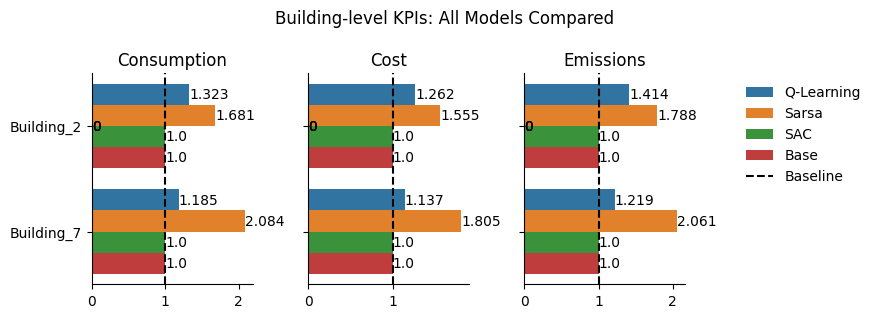

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


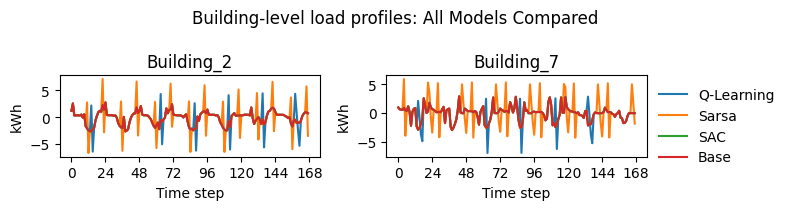

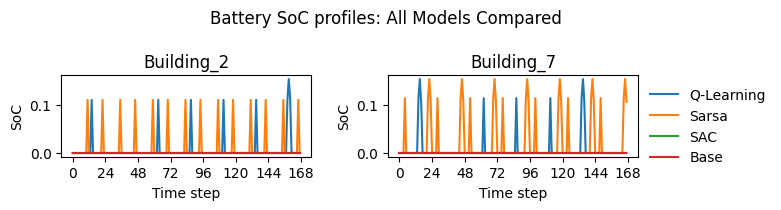

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


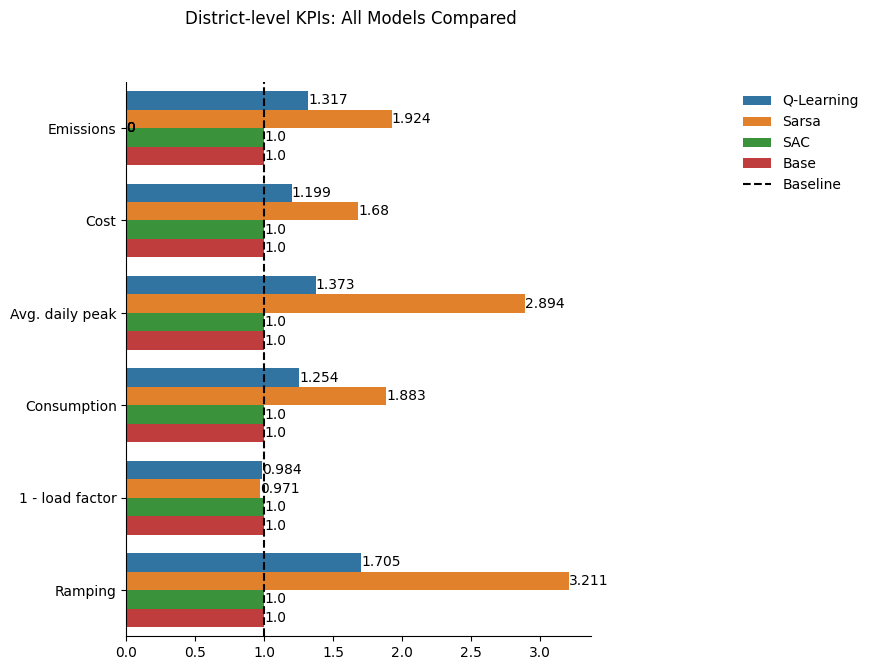

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.net_electricity_consumption to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption` for environment variables or `env.get_wrapper_attr('net_electricity_consumption')` that will search the reminding wrappers.
  logger.warn(


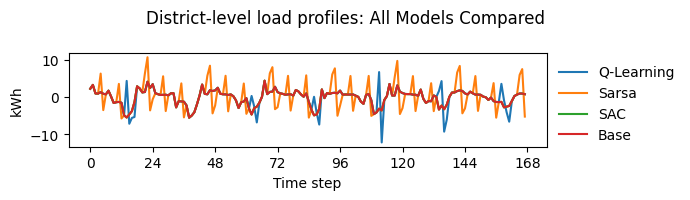

In [89]:
from functions.make_figures import plot_simulation_summary

plot_simulation_summary({'Q-Learning':q_env, 
                         'Sarsa': sarsa_env, 
                         'SAC':sac_env, 
                         # 'MADDPG':MADDPG_env, 
                         'Base': base_env},
                         "All Models Compared")

# Compare Tabular Models to Baseline

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


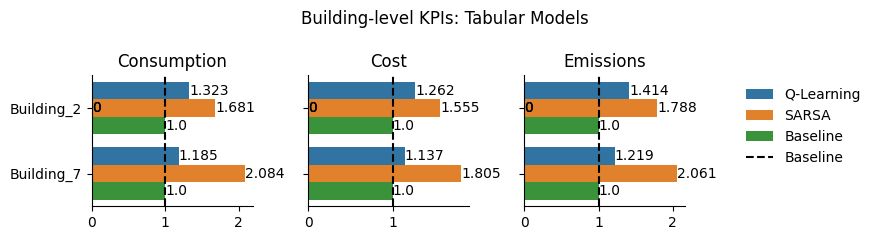

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


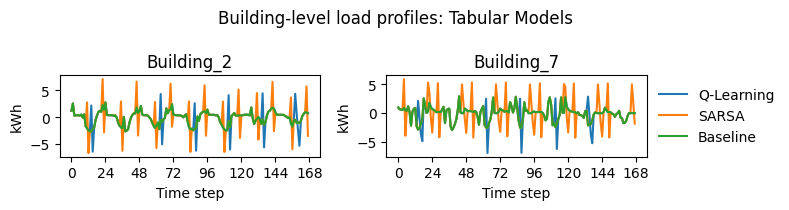

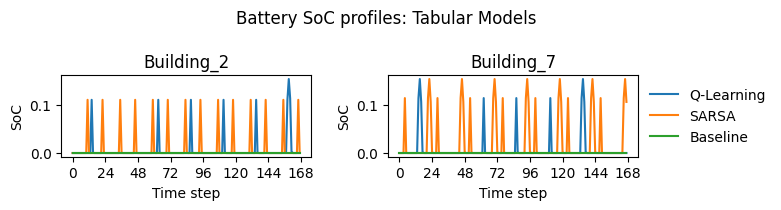

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


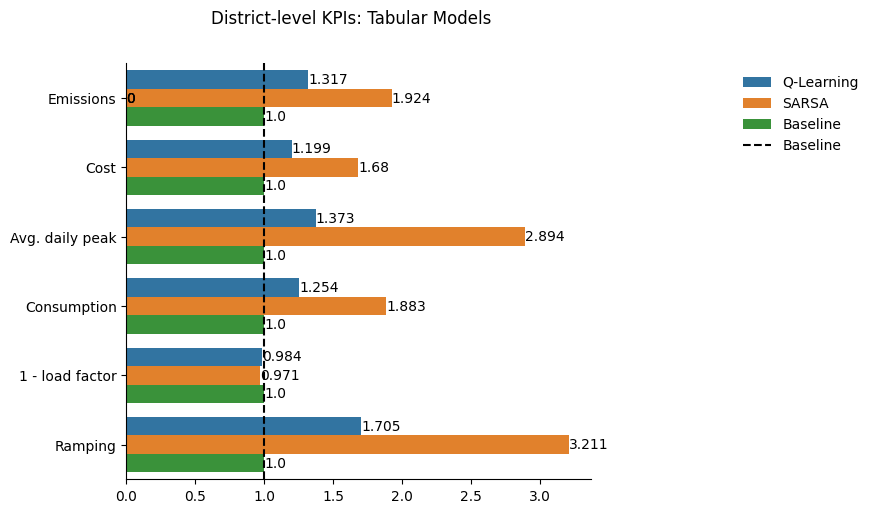

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.net_electricity_consumption to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption` for environment variables or `env.get_wrapper_attr('net_electricity_consumption')` that will search the reminding wrappers.
  logger.warn(


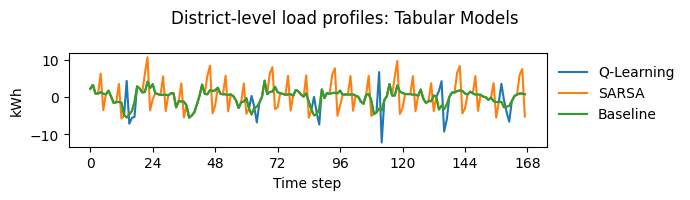

In [88]:
plot_simulation_summary({'Q-Learning':q_env, 
                         'SARSA':sarsa_env, 
                         'Baseline':base_env}, 
                         'Tabular Models')

# Compare Approximation Models to Baseline

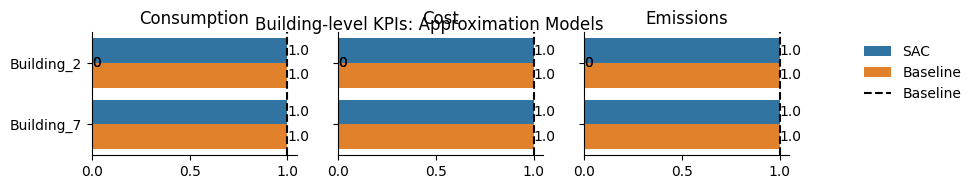

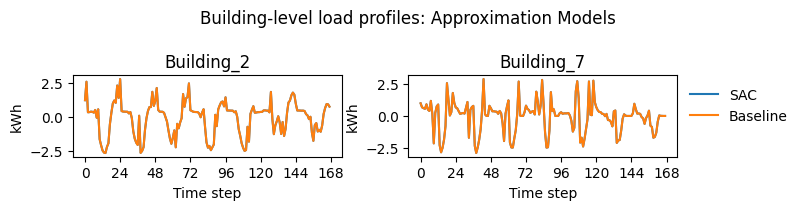

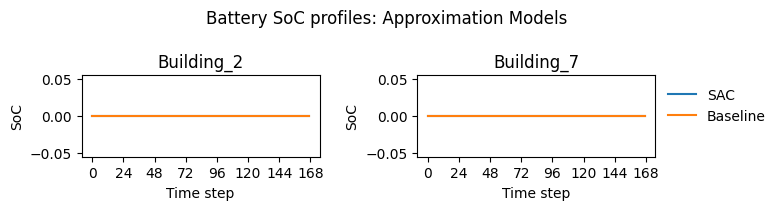

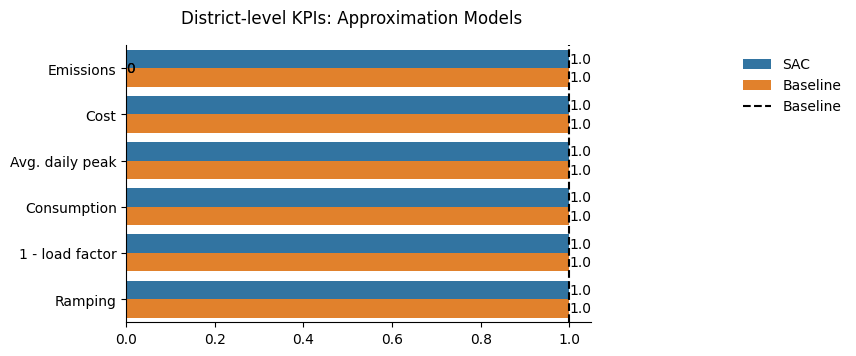

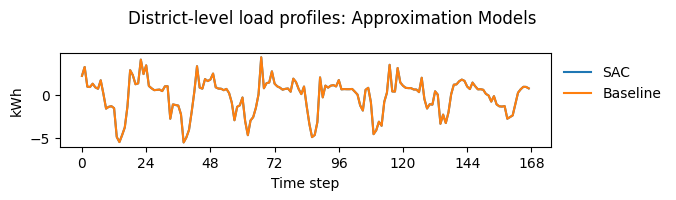

In [91]:
plot_simulation_summary({'SAC': sac_env,
                         #'MADDPG': MADDPG_env,
                         'Baseline': base_env},
                         'Approximation Models')